<a href="https://colab.research.google.com/github/Vignesh2216/Advanced-ML-Model-project/blob/main/Boosting_Imbalanced_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Preview:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26    

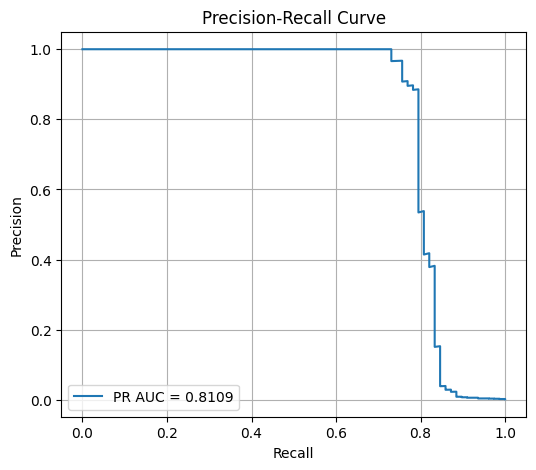


Classification Report (Tuned XGBoost):
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     40738
         1.0       0.12      0.82      0.21        78

    accuracy                           0.99     40816
   macro avg       0.56      0.90      0.60     40816
weighted avg       1.00      0.99      0.99     40816

Tuned ROC-AUC Score: 0.9628742332176472

Conclusion:
XGBoost with class imbalance handling techniques (SMOTE + class weighting)
significantly improves minority class detection in imbalanced datasets.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    auc
)

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier


# 2. Load Dataset
df = pd.read_csv("creditcard.csv")

# Display first few rows
print("Dataset Preview:")
print(df.head())

# 3. Check Class Distribution (Imbalance)
print("\nClass Distribution:")
print(df['Class'].value_counts())
print("\nClass Distribution (Percentage):")
print(df['Class'].value_counts(normalize=True))


# 4. Feature-Target Split
X = df.drop('Class', axis=1)
y = df['Class']

# Handle NaN values in 'y' before splitting (if any)
# Drop rows where 'y' is NaN, and apply the same index drop to 'X'
nan_rows = y.isnull()
if nan_rows.any():
    print(f"\nFound {nan_rows.sum()} NaN values in the target variable 'y'. Dropping these rows.")
    X = X[~nan_rows]
    y = y[~nan_rows]


# 5. Train-Test Split (Stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


# 6. Handle Class Imbalance
# ---- Technique 1: Class Weight ----
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print("\nScale Pos Weight:", scale_pos_weight)

# ---- Technique 2: SMOTE Oversampling ----
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE Class Distribution:")
print(pd.Series(y_train_sm).value_counts())


# 7. XGBoost Model Implementation
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    random_state=42
)

# Train the model
xgb_model.fit(X_train_sm, y_train_sm)


# 8. Predictions
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]


# 9. Model Evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC Score:", roc_auc)


# 10. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()


# 11. Hyperparameter Tuned XGBoost Model
xgb_tuned = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    random_state=42
)

# Train tuned model
xgb_tuned.fit(X_train_sm, y_train_sm)

# Predictions with tuned model
y_pred_tuned = xgb_tuned.predict(X_test)
y_prob_tuned = xgb_tuned.predict_proba(X_test)[:, 1]

print("\nClassification Report (Tuned XGBoost):")
print(classification_report(y_test, y_pred_tuned))

roc_auc_tuned = roc_auc_score(y_test, y_prob_tuned)
print("Tuned ROC-AUC Score:", roc_auc_tuned)


# 12. Final Conclusion
print("\nConclusion:")
print("XGBoost with class imbalance handling techniques (SMOTE + class weighting)")
print("significantly improves minority class detection in imbalanced datasets.")